In [1]:
import pandas as pd
import numpy as np
import cv2
import sys
import os
from datetime import datetime
from keras.applications import *
sys.path.append('..')
import imgaug as ia
from imgaug import augmenters as iaa
from glob import glob

import keras
import keras.layers as KL
import keras.backend as K
from keras.models import Model

import matplotlib.pyplot as plt

from src.triplet_generator import Generator
from src.metric_learning import triplet_semihard_loss
from src.metric_learning_probes import *


/home/gj/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/gj/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
DATA_PREPROCESSED = '/home/gj/whale_kaggle/data'

In [3]:
!nvidia-smi

Sat Jan 26 15:38:22 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.79       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 2070    Off  | 00000000:01:00.0  On |                  N/A |
| 29%   31C    P8    10W / 185W |    729MiB /  7952MiB |     20%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Make preprocessors

## Tail keypoint preprocessor

In [4]:
df = pd.read_csv('../data/tail_keypoints.csv')
keypoints = dict()

for i, row in df.iterrows():
    keypoints[row['image']] = [int(row['left_x']), int(row['left_y']), int(row['mid_x']), int(row['mid_y']), int(row['right_x']), int(row['right_y'])]

def preprocess_keypoints(img, path):
    keyp = keypoints[path.split('/')[-1]]
    M = cv2.getAffineTransform(
        np.array([(keyp[0], keyp[1]), (mx, my), (rx, ry)]).astype(np.float32),
        np.array([(20, 20), ((target_size[1] - 1)//2, (target_size[0] - 1)//2), ((target_size[1] - 1) - 20, 20)]).astype(np.float32),
    )
    dst = cv2.warpAffine(im, M, target_size[::-1])
    return dst
    
    

## Bounding box preprocessor

In [ ]:
df = pd.read_csv('../data/bounding_boxes.csv')
bboxes = dict()

for i, row in df.iterrows():
    bboxes[row['Image']] = [int(row['y0']), int(row['y1']), int(row['x0']), int(row['x1'])]
    
def preprocess_bboxes(img, path):
    bbox = bboxes[path.split('/')[-1]]
    return img[bbox[0]:bbox[1], bbox[2]:bbox[3]]

# Augmenter

In [ ]:
sometimes = lambda aug: iaa.Sometimes(0.3, aug)

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}, # scale images to 80-120% of their size, individually per axis
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # translate by -20 to +20 percent (per axis)
        rotate=(-15, 15), # rotate by -45 to +45 degrees
        shear=(-4, 4), # shear by -16 to +16 degrees
        order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
        cval=(0, 255), # if mode is constant, use a cval between 0 and 255
        mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
    ),
    sometimes(iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.01*255), per_channel=0.5)),
    sometimes(iaa.Sharpen(alpha=(0, 1.0), lightness=(0.9, 1.1))),
    #iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
    # search either for all edges or for directed edges,
    # blend the result with the original image using a blobby mask
    iaa.SimplexNoiseAlpha(iaa.OneOf([
        iaa.EdgeDetect(alpha=(0.5, 1.0)),
        iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
    ])),  
    iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
    iaa.AddToHueAndSaturation((-20, 20)) # change hue and saturation

])


# Model structure

In [ ]:
def feature_extractor(input_shape, base_model = ResNet50,
                    embedding_size = 256, reg = 1e-4, do = 0):


    base = base_model(input_shape = input_shape, include_top= False, pooling = 'max', weights='imagenet')
        
    shared_layers = KL.Dropout(do)(base.layers[-1].output)

    shared_layers = KL.Dense(embedding_size, activation='relu', name='embedding1')(shared_layers)
    shared_layers = KL.Dropout(do)(shared_layers)
    shared_layers = KL.Dense(embedding_size, activation='sigmoid', name='embedding2')(shared_layers)
    shared_layers = KL.Lambda(lambda x: K.l2_normalize(x, axis=-1), name = "embedding")(shared_layers)
    
    gold_nugget = Model(inputs = [base.input], outputs = [shared_layers])
    
    for layer in gold_nugget.layers:
        layer.kernel_regularizer = keras.regularizers.l2(reg)
        layer.bias_regularizer = keras.regularizers.l2(reg)

    return gold_nugget


# Hyperparameters

In [ ]:
size = 336
lr = 1e-4
embedding_size = 1024
reg = 1e-5
batch_size = 16
experiment = 'resnet50_embedding_1024'
MODEL_DIR = os.path.join('models',experiment + str(datetime.now().strftime('%Y-%m-%d-%H:%M:%S')))

# Revving up the generators

In [ ]:
train = glob(os.path.join(DATA_PREPROCESSED, 'train', '*')) 
val = glob(os.path.join(DATA_PREPROCESSED, 'val', '*'))

gen = Generator(train, target_dim = size, aug = seq, batch_size = batch_size)
val_gen = Generator(val, target_dim = size, batch_size = batch_size)

[array([11637., 11637.,  5427.,  5427.,  7003.,  7003.,  7003.,  8415.,
       10372., 10372.,  7827.,  7835.,  7835.,  6928.,  6928., 11887.],
      dtype=float32)]


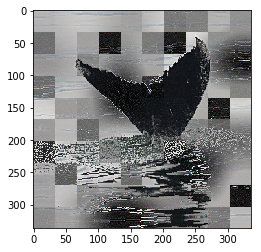

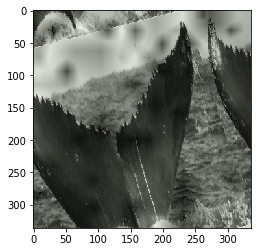

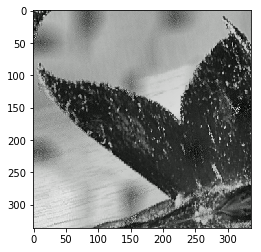

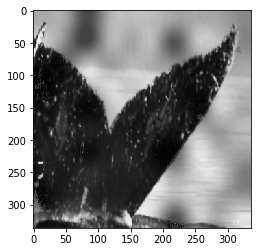

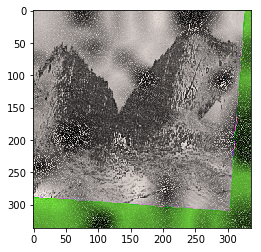

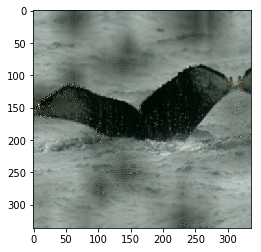

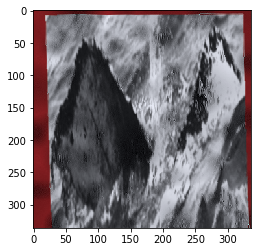

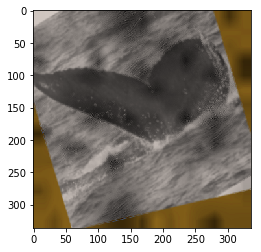

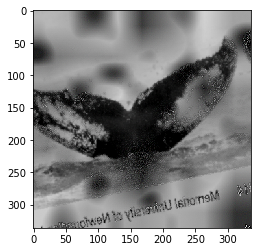

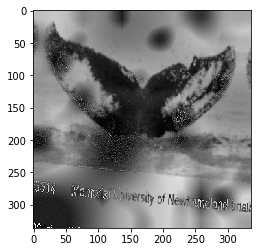

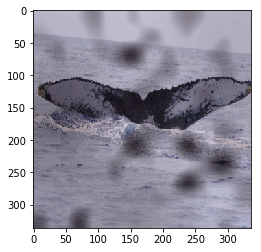

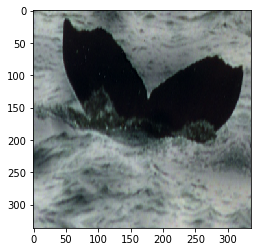

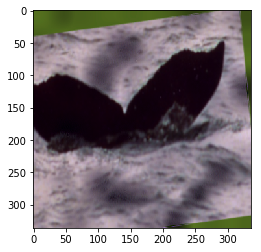

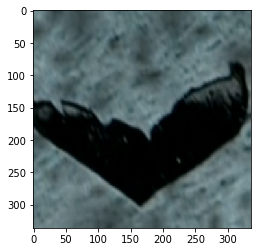

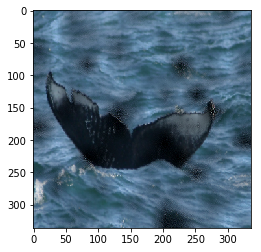

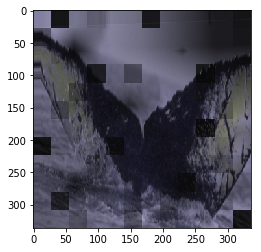

In [ ]:
x, y = gen.next()
print(y)

for sample in x[0]:
    plt.imshow(sample)
    plt.show()


# Setting up the model

In [ ]:
optim  = keras.optimizers.Adam(lr = lr)

model = feature_extractor((size, size, 3), reg = reg, embedding_size = embedding_size, base_model=ResNet50)

model.compile(loss=triplet_semihard_loss, 
              optimizer=optim, 
              metrics = [hardest_positive_dist, 
                         hardest_negative_dist, 
                         mean_positive_dist, 
                         mean_negative_dist, 
                         num_neg_pairs, 
                         num_pos_pairs])

model.summary()

callbacks = []
callbacks.append(keras.callbacks.ModelCheckpoint(os.path.join(MODEL_DIR, 'weights.{epoch:02d}')))
callbacks.append(keras.callbacks.TensorBoard(log_dir =  MODEL_DIR))

# And goooo

In [ ]:
model.fit_generator(
            generator=gen,
            validation_data =val_gen,
            validation_steps = len(val)/batch_size,
            steps_per_epoch= len(gen)/batch_size, epochs=500, callbacks = callbacks, verbose =1)